In [47]:
import torch
import numpy             as np
import matplotlib.pyplot as plt
import math

from sympy                    import *
from sympy                    import symbols, diff, simplify, exp, tanh, lambdify
from torch.optim              import Adam, LBFGS
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm                     import tqdm

init_printing()

# 1. Initialize

In [48]:
# Coordinates
r, theta, phi = symbols('r, theta, phi')
coords = [r, theta, phi]


# Horizon function
#h = Function('h')(phi)
h = Function('h')(theta)


# Additional symbols
N = symbols('N')
M = symbols('M')
R = symbols('R')


# ADM 3+1 components
alpha = Function('alpha')(r, theta, phi)   # lapse function
alpha = (1-M/(2*r)) / (1+M/(2*r))
#alpha = 1

beta = Array([0,0,0])                       # Shift vector

psi = Function('psi')(r, theta, phi)       # Conformal factor
psi = 1 + M/(2*r)
#psi = 1
psi4 = psi**4


# Flat metric and inverse
eta = diag(1, r**2, (r*sin(theta))**2)
eta_inv = eta**(-1)

***

# 2. Calculate expansion equation

In [49]:
# Run the file with all help functions

%run Apparent_horizon_conformal.ipynb

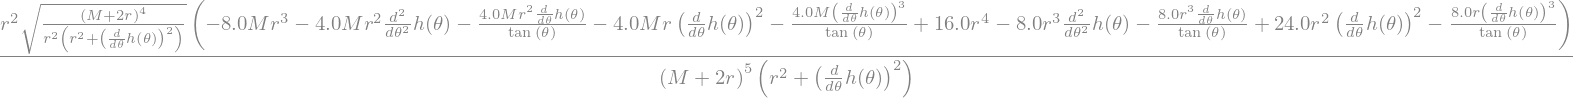

In [50]:
'''
Large function which calculates the expansion equation from alpha, beta, psi4, coordinates and h
'''



def final(alpha, beta, psi4, coords, h):
    '''
    param alpha: lapse function      --> function of (r, theta, phi)
    param beta: shift vector         --> 3-vector function of (r, theta, phi)
    param psi4: conformal factor     --> function of (r, theta, phi)
    param coords: coordinate system  --> list of coordinates
    param h: horizon function        --> scalar function dependent on theta, phi

    return: symbolic sympy expression of the expansion equation
    '''

    
    s_inv_norm = s_norm(h, psi4, coords, eta_inv)                       # inverse s-vector (normalized)
    
    christoffel = christoffel_symbols(psi4, eta, eta_inv, coords)       # Christoffel symbols of gamma 3-metric
    
    n_up = norm_up(alpha, beta, coords)                                 # normal vector to hypersurface (index up)
    
    n_down = norm_down(alpha, beta, psi4, eta, coords)                  # normal vector to hypersurface (index down)
    
    cur = extrinsic_curvature(n_up, n_down, christoffel, coords)        # extrinsic curvature (K_ij)
    
    exp = expansion(christoffel, s_inv_norm, cur, coords)               # expansion equation

    
    return exp



exp_eq = final(alpha, beta, psi4, coords, h)
display(sp.simplify(exp_eq))

***

# 3. Convert symbolic expression to string (pytorch compatible)

In [53]:
'''
Function which replaces theta derivatives with symbols and converts to a string
'''



from sympy.printing.lambdarepr import lambdarepr


# Define functions and symbols (--> up to 5th order derivatives can be replaced)
x = Function('x')(theta)
y = Function('y')(theta)
z = Function('z')(theta)
u = Function('u')(theta)
v = Function('v')(theta)
H, X, Y, Z, U, V = symbols('H, X, Y, Z, U, V')
funcs_pre = [h, x, y, z, u, v]
syms_pre = [H, X, Y, Z, U, V]


# Replace each theta derivative with a unique symbol for string conversion
def subs_der(expr, nr_der):
    '''
    params expr: symbolic expression in which to replace derivatives
    params nr_der: highest order of desired derivative to be replaced

    return: string with r replaced by H and derivatives replaced by symbols X, Y, ...
    '''
    
    funcs = []
    syms = []
    for i in range(nr_der+1):
        funcs.append(funcs_pre[i])
        syms.append(syms_pre[i])
    n = len(funcs)
    expr = expr.subs(r, h)
    for i in range(n-1):
        expr = expr.subs(diff(funcs[i], theta), funcs[i+1])
    for i in range(n):
        expr = expr.subs(funcs[i], syms[i])
        
    return lambdarepr(expr)

symp_expr = subs_der(exp_eq, 2)
print(symp_expr)

2*(1.0/H - 1.0*M/(H**2*(1 + (1/2)*M/H)))*sqrt(1/((1 + (1/2)*M/H)**(-4) + X**2/(H**2*(1 + (1/2)*M/H)**4)))/(1 + (1/2)*M/H)**4 + (1/2)*(-2*M/(H**2*(1 + (1/2)*M/H)**5) + 2*X**2/(H**3*(1 + (1/2)*M/H)**4) - 2*M*X**2/(H**4*(1 + (1/2)*M/H)**5))*sqrt(1/((1 + (1/2)*M/H)**(-4) + X**2/(H**2*(1 + (1/2)*M/H)**4)))/((1 + (1/2)*M/H)**4*((1 + (1/2)*M/H)**(-4) + X**2/(H**2*(1 + (1/2)*M/H)**4))) + 1.0*M*sqrt(1/((1 + (1/2)*M/H)**(-4) + X**2/(H**2*(1 + (1/2)*M/H)**4)))/(H**2*(1 + (1/2)*M/H)**5) - 1.0*X*sqrt(1/((1 + (1/2)*M/H)**(-4) + X**2/(H**2*(1 + (1/2)*M/H)**4)))*math.cos(theta)/(H**2*(1 + (1/2)*M/H)**4*math.sin(theta)) - Y*sqrt(1/((1 + (1/2)*M/H)**(-4) + X**2/(H**2*(1 + (1/2)*M/H)**4)))/(H**2*(1 + (1/2)*M/H)**4) + X**2*Y*sqrt(1/((1 + (1/2)*M/H)**(-4) + X**2/(H**2*(1 + (1/2)*M/H)**4)))/(H**4*(1 + (1/2)*M/H)**8*((1 + (1/2)*M/H)**(-4) + X**2/(H**2*(1 + (1/2)*M/H)**4)))


In [55]:
'''
Function which makes the string pytorch-compatible
'''


#dic = {"math.sin(theta)":"1", "math.":"torch.", "sqrt":"torch.sqrt"}   # phi case (take sin(theta)=1)
dic = {"math.":"torch.", "sqrt":"torch.sqrt"}   # theta case

def replace_all(expr, dic):
    for i, j in dic.items():
        expr = expr.replace(i, j)
    return expr

expr = replace_all(symp_expr, dic)
#test_repl = replace_all(test, dic)

print(expr)

2*(1.0/H - 1.0*M/(H**2*(1 + (1/2)*M/H)))*torch.sqrt(1/((1 + (1/2)*M/H)**(-4) + X**2/(H**2*(1 + (1/2)*M/H)**4)))/(1 + (1/2)*M/H)**4 + (1/2)*(-2*M/(H**2*(1 + (1/2)*M/H)**5) + 2*X**2/(H**3*(1 + (1/2)*M/H)**4) - 2*M*X**2/(H**4*(1 + (1/2)*M/H)**5))*torch.sqrt(1/((1 + (1/2)*M/H)**(-4) + X**2/(H**2*(1 + (1/2)*M/H)**4)))/((1 + (1/2)*M/H)**4*((1 + (1/2)*M/H)**(-4) + X**2/(H**2*(1 + (1/2)*M/H)**4))) + 1.0*M*torch.sqrt(1/((1 + (1/2)*M/H)**(-4) + X**2/(H**2*(1 + (1/2)*M/H)**4)))/(H**2*(1 + (1/2)*M/H)**5) - 1.0*X*torch.sqrt(1/((1 + (1/2)*M/H)**(-4) + X**2/(H**2*(1 + (1/2)*M/H)**4)))*torch.cos(theta)/(H**2*(1 + (1/2)*M/H)**4*torch.sin(theta)) - Y*torch.sqrt(1/((1 + (1/2)*M/H)**(-4) + X**2/(H**2*(1 + (1/2)*M/H)**4)))/(H**2*(1 + (1/2)*M/H)**4) + X**2*Y*torch.sqrt(1/((1 + (1/2)*M/H)**(-4) + X**2/(H**2*(1 + (1/2)*M/H)**4)))/(H**4*(1 + (1/2)*M/H)**8*((1 + (1/2)*M/H)**(-4) + X**2/(H**2*(1 + (1/2)*M/H)**4)))


***

# 4. PyTorch solver (phi case)

In [39]:
N_ph = 100
phi = torch.linspace(-4*torch.pi, 4*torch.pi, N_ph, dtype=torch.float64)

h = torch.ones(N_ph, dtype=torch.float64, requires_grad=True)
h.data = 0.95*h.data

In [40]:
dic_solve = {"H":"h_2", "phi":"ph_2", "X":"(d_h/d_ph)", "Y":"(d2_h/d_ph)", "M":"2"}

def replace_solve(expr, dic):
    for i, j in dic.items():
        expr = expr.replace(i, j)
    return expr

expr = replace_all(expr, dic_solve)
print(expr)

2*(1.0/h_2 - 1.0*2/(h_2**2*(1 + (1/2)*2/h_2)))*torch.sqrt(1/((1 + (1/2)*2/h_2)**(-4) + (d_h/d_ph)**2/(h_2**2*(1 + (1/2)*2/h_2)**4*1**2)))/(1 + (1/2)*2/h_2)**4 + (1/2)*(-2*2/(h_2**2*(1 + (1/2)*2/h_2)**5) + 2*(d_h/d_ph)**2/(h_2**3*(1 + (1/2)*2/h_2)**4*1**2) - 2*2*(d_h/d_ph)**2/(h_2**4*(1 + (1/2)*2/h_2)**5*1**2))*torch.sqrt(1/((1 + (1/2)*2/h_2)**(-4) + (d_h/d_ph)**2/(h_2**2*(1 + (1/2)*2/h_2)**4*1**2)))/((1 + (1/2)*2/h_2)**4*((1 + (1/2)*2/h_2)**(-4) + (d_h/d_ph)**2/(h_2**2*(1 + (1/2)*2/h_2)**4*1**2))) + 1.0*2*torch.sqrt(1/((1 + (1/2)*2/h_2)**(-4) + (d_h/d_ph)**2/(h_2**2*(1 + (1/2)*2/h_2)**4*1**2)))/(h_2**2*(1 + (1/2)*2/h_2)**5) - (d2_h/d_ph)*torch.sqrt(1/((1 + (1/2)*2/h_2)**(-4) + (d_h/d_ph)**2/(h_2**2*(1 + (1/2)*2/h_2)**4*1**2)))/(h_2**2*(1 + (1/2)*2/h_2)**4*1**2) + (d_h/d_ph)**2*(d2_h/d_ph)*torch.sqrt(1/((1 + (1/2)*2/h_2)**(-4) + (d_h/d_ph)**2/(h_2**2*(1 + (1/2)*2/h_2)**4*1**2)))/(h_2**4*(1 + (1/2)*2/h_2)**8*((1 + (1/2)*2/h_2)**(-4) + (d_h/d_ph)**2/(h_2**2*(1 + (1/2)*2/h_2)**4*1**2))*1**

In [41]:
def h_loss(h, expr):
    # Define auxiliary variables
    h_1 = 0.5 * (h[1:] + h[:-1])
    h_2 = 0.5 * (h_1[1:] + h_1[:-1])
    ph_1 = 0.5 * (phi[1:] + phi[:-1])
    ph_2 = 0.5 * (ph_1[1:] + ph_1[:-1])
    
    
    d_h_temp = torch.diff(h)
    d_h = 0.5 * (d_h_temp[1:] + d_h_temp[:-1])
    d_ph_temp = torch.diff(phi)
    d_ph = torch.mean(d_ph_temp)
    
    d2_h = torch.diff(h, 2)

    
    # Define residual of the equation by evaluating the string expression above
    #residual = eval(expr)
    residual = 2*(1.0/h_2 - 1.0*2/(h_2**2*(1 + (1/2)*2/h_2)))*torch.sqrt(1/((1 + (1/2)*2/h_2)**(-4) + (d_h/d_ph)**2/(h_2**2*(1 + (1/2)*2/h_2)**4*1**2)))/(1 + (1/2)*2/h_2)**4 + (1/2)*(-2*2/(h_2**2*(1 + (1/2)*2/h_2)**5) + 2*(d_h/d_ph)**2/(h_2**3*(1 + (1/2)*2/h_2)**4*1**2) - 2*2*(d_h/d_ph)**2/(h_2**4*(1 + (1/2)*2/h_2)**5*1**2))*torch.sqrt(1/((1 + (1/2)*2/h_2)**(-4) + (d_h/d_ph)**2/(h_2**2*(1 + (1/2)*2/h_2)**4*1**2)))/((1 + (1/2)*2/h_2)**4*((1 + (1/2)*2/h_2)**(-4) + (d_h/d_ph)**2/(h_2**2*(1 + (1/2)*2/h_2)**4*1**2))) + 1.0*2*torch.sqrt(1/((1 + (1/2)*2/h_2)**(-4) + (d_h/d_ph)**2/(h_2**2*(1 + (1/2)*2/h_2)**4*1**2)))/(h_2**2*(1 + (1/2)*2/h_2)**5) - (d2_h/d_ph)*torch.sqrt(1/((1 + (1/2)*2/h_2)**(-4) + (d_h/d_ph)**2/(h_2**2*(1 + (1/2)*2/h_2)**4*1**2)))/(h_2**2*(1 + (1/2)*2/h_2)**4*1**2) + (d_h/d_ph)**2*(d2_h/d_ph)*torch.sqrt(1/((1 + (1/2)*2/h_2)**(-4) + (d_h/d_ph)**2/(h_2**2*(1 + (1/2)*2/h_2)**4*1**2)))/(h_2**4*(1 + (1/2)*2/h_2)**8*((1 + (1/2)*2/h_2)**(-4) + (d_h/d_ph)**2/(h_2**2*(1 + (1/2)*2/h_2)**4*1**2))*1**4)
    
    # Return the mean squared residual
    return torch.mean(residual**2)

In [42]:
def solve_for_h(h, expr, N_iter=150, lr=1.0e-2):
    # Define variable to store the loss history
    losses = np.empty(N_iter)
    # Define optimiser and scheduler
    optimiser = Adam([h], lr=lr)
    scheduler = ReduceLROnPlateau(optimiser, mode='min', factor=0.5, patience=200)
    # Iteratatively minimise loss
    for i in tqdm(range(N_iter)):
        # Compute the loss
        loss      = h_loss(h, expr)
        losses[i] = loss.item()
        # Set gradients to zero
        optimiser.zero_grad()
        # Backpropagate gradients
        loss.backward()
        # Update parameters and scheduler
        optimiser.step()
        scheduler.step(loss)
    # Return result and loss history
    return h, losses

In [43]:
h, h_losses = solve_for_h(h, expr, N_iter=150, lr=1.0e-2)

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 201.63it/s]


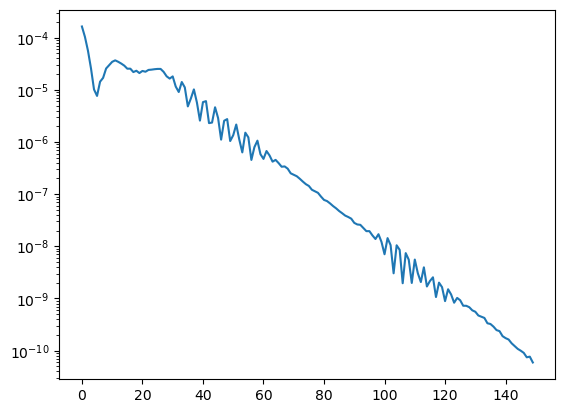

In [44]:
plt.plot(h_losses)
plt.yscale('log')

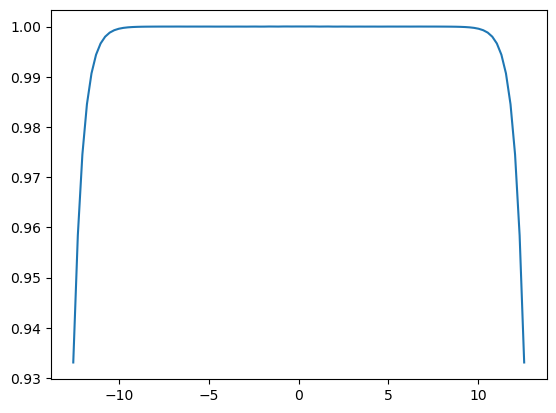

In [45]:
plt.plot(phi, h.data);

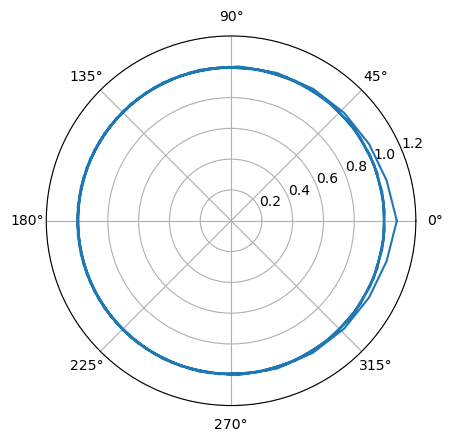

In [66]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(phi, h.data)
ax.set_rmax(1.2)
ax.grid(True)
plt.show()

# 5. PyTorch solver (theta case)

In [151]:
N_th = 100
theta = torch.linspace(0, torch.pi, N_th, dtype=torch.float64)

h = torch.ones(N_th, dtype=torch.float64, requires_grad=True)
h.data = 0.95*h.data

In [152]:
dic_solve = {"H":"h_2", "theta":"th_2", "X":"(d_h/d_th)", "Y":"(d2_h/d_th)", "M":"2"}

def replace_solve(expr, dic):
    for i, j in dic.items():
        expr = expr.replace(i, j)
    return expr

expr = replace_all(expr, dic_solve)
print(expr)

2*(1.0/h_2 - 1.0*2/(h_2**2*(1 + (1/2)*2/h_2)))*torch.sqrt(1/((1 + (1/2)*2/h_2)**(-4) + (d_h/d_th)**2/(h_2**2*(1 + (1/2)*2/h_2)**4)))/(1 + (1/2)*2/h_2)**4 + (1/2)*(-2*2/(h_2**2*(1 + (1/2)*2/h_2)**5) + 2*(d_h/d_th)**2/(h_2**3*(1 + (1/2)*2/h_2)**4) - 2*2*(d_h/d_th)**2/(h_2**4*(1 + (1/2)*2/h_2)**5))*torch.sqrt(1/((1 + (1/2)*2/h_2)**(-4) + (d_h/d_th)**2/(h_2**2*(1 + (1/2)*2/h_2)**4)))/((1 + (1/2)*2/h_2)**4*((1 + (1/2)*2/h_2)**(-4) + (d_h/d_th)**2/(h_2**2*(1 + (1/2)*2/h_2)**4))) + 1.0*2*torch.sqrt(1/((1 + (1/2)*2/h_2)**(-4) + (d_h/d_th)**2/(h_2**2*(1 + (1/2)*2/h_2)**4)))/(h_2**2*(1 + (1/2)*2/h_2)**5) - 1.0*(d_h/d_th)*torch.sqrt(1/((1 + (1/2)*2/h_2)**(-4) + (d_h/d_th)**2/(h_2**2*(1 + (1/2)*2/h_2)**4)))*1/(h_2**2*(1 + (1/2)*2/h_2)**4*1) - (d2_h/d_th)*torch.sqrt(1/((1 + (1/2)*2/h_2)**(-4) + (d_h/d_th)**2/(h_2**2*(1 + (1/2)*2/h_2)**4)))/(h_2**2*(1 + (1/2)*2/h_2)**4) + (d_h/d_th)**2*(d2_h/d_th)*torch.sqrt(1/((1 + (1/2)*2/h_2)**(-4) + (d_h/d_th)**2/(h_2**2*(1 + (1/2)*2/h_2)**4)))/(h_2**4*(1 + (1/2

In [153]:
def h_loss(h, expr):
    # Define auxiliary variables
    h_1 = 0.5 * (h[1:] + h[:-1])
    h_2 = 0.5 * (h_1[1:] + h_1[:-1])
    th_1 = 0.5 * (theta[1:] + theta[:-1])
    th_2 = 0.5 * (th_1[1:] + th_1[:-1])
    
    
    d_h_temp = torch.diff(h)
    d_h = 0.5 * (d_h_temp[1:] + d_h_temp[:-1])
    d_th_temp = torch.diff(theta)
    d_th = torch.mean(d_th_temp)
    
    d2_h = torch.diff(h, 2)

    
    # Define residual of the equation by evaluating the string expression above
    #residual = eval(expr)
    residual = 2*(1.0/h_2 - 1.0*2/(h_2**2*(1 + (1/2)*2/h_2)))*torch.sqrt(1/((1 + (1/2)*2/h_2)**(-4) + (d_h/d_th)**2/(h_2**2*(1 + (1/2)*2/h_2)**4)))/(1 + (1/2)*2/h_2)**4 + (1/2)*(-2*2/(h_2**2*(1 + (1/2)*2/h_2)**5) + 2*(d_h/d_th)**2/(h_2**3*(1 + (1/2)*2/h_2)**4) - 2*2*(d_h/d_th)**2/(h_2**4*(1 + (1/2)*2/h_2)**5))*torch.sqrt(1/((1 + (1/2)*2/h_2)**(-4) + (d_h/d_th)**2/(h_2**2*(1 + (1/2)*2/h_2)**4)))/((1 + (1/2)*2/h_2)**4*((1 + (1/2)*2/h_2)**(-4) + (d_h/d_th)**2/(h_2**2*(1 + (1/2)*2/h_2)**4))) + 1.0*2*torch.sqrt(1/((1 + (1/2)*2/h_2)**(-4) + (d_h/d_th)**2/(h_2**2*(1 + (1/2)*2/h_2)**4)))/(h_2**2*(1 + (1/2)*2/h_2)**5) - 1.0*(d_h/d_th)*torch.sqrt(1/((1 + (1/2)*2/h_2)**(-4) + (d_h/d_th)**2/(h_2**2*(1 + (1/2)*2/h_2)**4)))*1/(h_2**2*(1 + (1/2)*2/h_2)**4*1) - (d2_h/d_th)*torch.sqrt(1/((1 + (1/2)*2/h_2)**(-4) + (d_h/d_th)**2/(h_2**2*(1 + (1/2)*2/h_2)**4)))/(h_2**2*(1 + (1/2)*2/h_2)**4) + (d_h/d_th)**2*(d2_h/d_th)*torch.sqrt(1/((1 + (1/2)*2/h_2)**(-4) + (d_h/d_th)**2/(h_2**2*(1 + (1/2)*2/h_2)**4)))/(h_2**4*(1 + (1/2)*2/h_2)**8*((1 + (1/2)*2/h_2)**(-4) + (d_h/d_th)**2/(h_2**2*(1 + (1/2)*2/h_2)**4)))
    # Return the mean squared residual
    return torch.mean(residual**2)

In [154]:
def solve_for_h(h, expr, N_iter=200, lr=1.0e-2):
    # Define variable to store the loss history
    losses = np.empty(N_iter)
    # Define optimiser and scheduler
    optimiser = Adam([h], lr=lr)
    scheduler = ReduceLROnPlateau(optimiser, mode='min', factor=0.5, patience=200)
    # Iteratatively minimise loss
    for i in tqdm(range(N_iter)):
        # Compute the loss
        loss      = h_loss(h, expr)
        losses[i] = loss.item()
        # Set gradients to zero
        optimiser.zero_grad()
        # Backpropagate gradients
        loss.backward()
        # Update parameters and scheduler
        optimiser.step()
        scheduler.step(loss)
    # Return result and loss history
    return h, losses

In [155]:
h, h_losses = solve_for_h(h, expr, N_iter=200, lr=1.0e-2)

100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 159.47it/s]


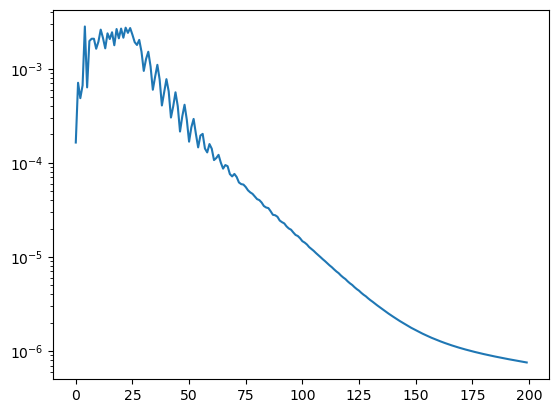

In [156]:
plt.plot(h_losses)
plt.yscale('log')

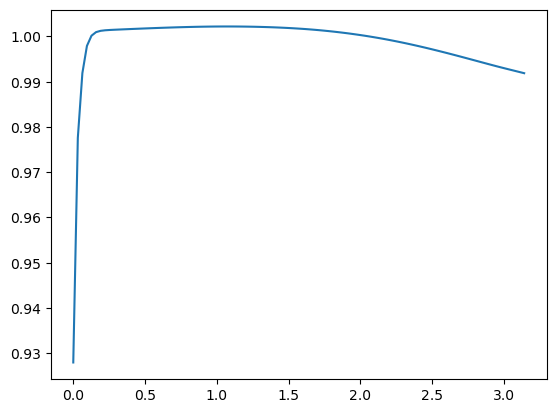

In [157]:
plt.plot(theta, h.data);

***

# Backup

In [ ]:
'''
# Theta linspace
N_th = 3
theta = torch.linspace(0.001, torch.pi, N_th, dtype=torch.float64)
#a = torch.tensor([theta[0]])
#theta_new = torch.cat((theta, a))  # Add first element at the back of the tensor

# Initialize h-function
h = torch.ones(N_th, dtype=torch.float64, requires_grad=True)
h.data = 0.4*h.data
b = torch.tensor([h[0]])
h_new = torch.cat((h, b))  # Add first element at the back of the tensor

print(h)
'''

'''
d_th = torch.diff(theta)
mean_th = torch.mean(d_th)
print(mean_th)

d_h = torch.diff(h_new)


c = torch.tensor([d_th[0]])
d_th_new = torch.cat((d_th, c))
d = torch.tensor([d_h[0]])
d_h_new = torch.cat((d_h, d))

d2_th = torch.diff(d_th_new)
d2_h = torch.diff(d_h_new)

print(theta.shape, h.shape, d_th.shape, d_h.shape, d2_th.shape, d2_h.shape)
'''

'''
dic_solve = {"H":"h", "X":"(d_h/mean_th)", "Y":"(d2_h/mean_th)", "M":"1", "theta":"1"}
#dic_solve = {"H":"h", "X":"(d_h/d_th)", "Y":"0", "M":"1"}

def replace_solve(expr, dic):
    for i, j in dic.items():
        expr = expr.replace(i, j)
    return expr

expr = replace_all(expr, dic_solve)
print(expr)
'''

***

# Old solver

In [9]:
Nr = 1
r = torch.ones(Nr, dtype=torch.float64, requires_grad=True)

def r_loss(r):
    # Define residual of the equation
    residual = 1/r**5 * ((r-1.5) * (1+2*r)**3)
    # Return the mean squared residual
    return torch.mean(residual**2)

In [10]:
def solve_for_r(r, N_iter=1000, lr=1.0e-3):
    # Define variable to store the loss history
    losses = np.empty(N_iter)
    # Define optimiser and scheduler
    optimiser = Adam([r], lr=lr)
    scheduler = ReduceLROnPlateau(optimiser, mode='min', factor=0.5, patience=200)
    # Iteratatively minimise loss
    for i in tqdm(range(N_iter)):
        # Compute the loss
        loss      = r_loss(r=r)
        losses[i] = loss.item()
        # Set gradients to zero
        optimiser.zero_grad()
        # Backpropagate gradients
        loss.backward()
        # Update parameters and scheduler
        optimiser.step()
        scheduler.step(loss)
    # Return result and loss history
    return r, losses

In [11]:
r, r_losses = solve_for_r(r=r, N_iter=10000, lr=1.0e-3)

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1385.57it/s]


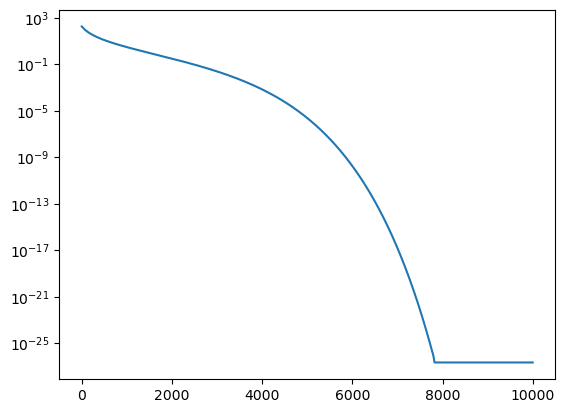

In [12]:
plt.plot(r_losses)
plt.yscale('log')

In [14]:
print(r)

tensor([1.5000], dtype=torch.float64, requires_grad=True)
